# Necessary imports

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from skimage import io
import time
import os
import copy
from torch.utils.data import Dataset
from PIL import Image

from torchvision.utils import make_grid
import torch.nn.functional as F
cudnn.benchmark = True

# Copy sample data from one folder to another

In [2]:
# from tqdm import tqdm
# import shutil

# data_dir = '/home/ml_user/Downloads/final_project/train/'
# destination_dir = "/home/ml_user/Downloads/Arman_final_project_sample/"
# parent_list = os.listdir(data_dir)
# print(parent_list)

# for folder in os.listdir(data_dir):
#     count = 0 
#     current_directory = os.path.join(destination_dir, folder)
#     if not os.path.exists(current_directory):
#         os.mkdir(current_directory)
#     for image in tqdm(os.listdir(os.path.join(data_dir, folder))):
#         if count < 1000:
#             image_path = os.path.join(data_dir + folder, image)
#             shutil.copy(image_path, os.path.join(destination_dir + folder, image))
#         else:
#             break
#         count += 1

# How to mount google drive to colab

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

# Check device whether cpu or gpu

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Data augmentation and normalization for training

In [5]:
# Just normalization for validation

# data_transforms = {
#     'train': transforms.Compose([
#         transforms.RandomResizedCrop(224),
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
#     'val': transforms.Compose([
#         transforms.Resize(256),
#         transforms.CenterCrop(224),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
# }

# How to read data with pytorch imagefolder

In [6]:
# Your data must be organized in separate folders each folder with the name the label and the images inside it 
# So if you have newspaper folder than all the newspaper images and files must be in that folder
data_dir = '/home/ml_user/Downloads/Arman_final_project_sample/'

#image_datasets = datasets.ImageFolder(data_dir, data_transforms['train'])
image_datasets = datasets.ImageFolder(data_dir)
image_datasets

Dataset ImageFolder
    Number of datapoints: 13000
    Root location: /home/ml_user/Downloads/Arman_final_project_sample/

# How to calculate mean and standart deviation of the images and apply transformations

In [7]:
def compute_mean_and_std():
    batch_size = 128
    image_datasets.transform =  transforms.Compose([
                    transforms.Resize((224, 224)),
                    transforms.ToTensor()])

    loader = torch.utils.data.DataLoader(image_datasets, batch_size=batch_size, shuffle=True, num_workers=2)

    psum    = torch.tensor([0.0, 0.0, 0.0])
    psum_sq = torch.tensor([0.0, 0.0, 0.0])

    for inputs, labels in loader:
        psum    += inputs.sum(axis=[0, 2, 3])
        psum_sq += (inputs ** 2).sum(axis=[0, 2, 3])

    # pixel count
    count = len(image_datasets) * 224 * 224

    # mean and std
    total_mean = psum / count
    total_var  = (psum_sq / count) - (total_mean ** 2)
    total_std  = torch.sqrt(total_var)

    # output
    print('mean: '  + str(total_mean))
    print('std:  '  + str(total_std))

In [8]:
# compute_mean_and_std()

# How to split split train and test data

In [9]:
import torch.utils.data as torch_data

train_set_size = int(len(image_datasets) * 0.8)
valid_set_size = len(image_datasets) - train_set_size
train_set, valid_set = torch_data.random_split(image_datasets, [train_set_size, valid_set_size])

# How to apply the transformations to the dataset

In [10]:
train_data_transforms = transforms.Compose([
                transforms.Resize((256, 256)),
                transforms.RandomResizedCrop((224, 224)),
                transforms.ToTensor(),
                # Here normalize uses the computed mean and std
                transforms.Normalize(mean=0.9151, std=0.2046)
            ])

test_data_transforms = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                # Here normalize uses the computed mean and std
                transforms.Normalize(mean=0.9151, std=0.2046)
            ])

train_set.dataset.transform = train_data_transforms
valid_set.dataset.transform = test_data_transforms

# Get the train and validation loaders

In [11]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, num_workers=6)
val_loader = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=True, num_workers=6)

#dataset_sizes = {x: len(image_datasets[x]) for x in ['train']}

class_names = image_datasets.classes
print(class_names)

['ad', 'cv', 'email', 'file', 'handwritten', 'invoice', 'letter', 'memorandum', 'newspaper', 'publication', 'report', 'specification', 'survey']


# Make sure the train and validation loader are set correctly 

In [12]:
for x, target in train_loader:
    print(x.shape)
    print(target)
    break

torch.Size([32, 3, 224, 224])
tensor([11,  7,  4,  6,  8,  1,  7,  0, 12, 11,  2, 11,  6,  2,  1,  7,  6,  1,
         2,  3,  5,  7,  9,  0,  4, 12, 11, 10,  8,  4,  4,  2])


# Plot the images with their labels 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: [   10     1     3     5     4     7    12     9    12     5     4     8
    11     8     0     6     1    11    10     3    11    11     5     2
    10    10     2     3     9     1    10     8]
Class:  report cv file invoice handwritten memorandum survey publication survey invoice handwritten newspaper specification newspaper ad letter cv specification report file specification specification invoice email report report email file publication cv report newspaper


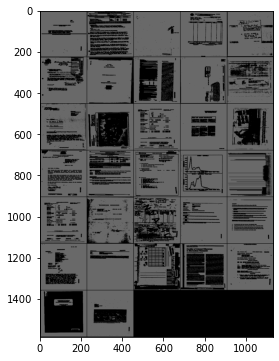

In [13]:
np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}')) # to widen the printed array

# Grab the first batch of 10 images
for images,labels in train_loader: 
    break

# Print the labels
print('Label:', labels.numpy())
print('Class: ', *np.array([class_names[i] for i in labels]))

# Print the images
im = make_grid(images, nrow=5)  # the default nrow is 8
plt.figure(figsize=(12,6))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

# Try couple of architectures 

In [14]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)  # changed from (1, 6, 5, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(54*54*16, 120)   
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84, 13)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 54*54*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

# Another conv architecture

In [15]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)  # changed from (1, 6, 5, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.conv3 = nn.Conv2d(16, 32, 3, 1)
        self.fc1 = nn.Linear(52*52*32, 1024)   # changed from (4*4*16) to fit 32x32 images with 3x3 filters
        self.fc2 = nn.Linear(1024,512)
        self.fc3 = nn.Linear(512, 13)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv3(X))
        X = X.view(-1, 114*114*32)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [16]:
torch.manual_seed(101)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=86528, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=13, bias=True)
)

# How to count parameters of the network

In [17]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [18]:
count_parameters(model)

   162
     6
   864
    16
  4608
    32
88604672
  1024
524288
   512
  6656
    13
______
89142853


# How to use the vgg model and adjust the last layer according number of classess

In [19]:
from traitlets.traitlets import ForwardDeclaredInstance
from torchvision import models

vgg16 = models.vgg16(pretrained=False)

num_classes = 13

vgg16.classifier = nn.Linear(25088, num_classes)
vgg16.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Define loss function & optimizer

In [20]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg16.parameters(), lr=0.0001, weight_decay=0.015)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.3)

## Train the model
This time we'll feed the data directly into the model without flattening it first.<br>
<div class="alert alert-info"><font color=blue><strong>OPTIONAL: </strong>In the event that training takes too long, you can interrupt the kernel, skip ahead to the bottom of the notebook, and load a trained version of the model that's been saved in this folder.</font></div>

# One way of training our model 

In [21]:
from tqdm import tqdm

epochs = 5
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in tqdm(range(epochs)):

    torch.cuda.empty_cache()
    
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
  
    for batch_idx, (inputs, labels) in tqdm(enumerate(train_loader)):
        
        
#         if batch_idx % 10 == 0:
#             print(f"Batch {batch_idx} from {len(train_loader)} of epoch {e + 1}")
            
        inputs = inputs.to(device)
        labels = labels.to(device)
        vgg16.train()
        outputs = vgg16(inputs)                      # predict using the model class

        loss = criterion(outputs, labels)           # calculate the loss

        optimizer.zero_grad()                       # make the gradients zero so as to not accumulate
        loss.backward()                             # backward is to calculate the gradients
        optimizer.step()                            # update the weights using the step fucntion 

        _, preds = torch.max(outputs, 1)            
        running_loss += loss.item()                 
        running_corrects += torch.sum(preds == labels.data)  

        del inputs
        del labels

    else:
        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                
                #val_inputs = val_inputs.view(val_inputs.shape[0], -1)   # flattten if we have neural net architecture
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)
                val_outputs = vgg16(val_inputs)                    # predict
                val_loss = criterion(val_outputs, val_labels)           # calculate loss

                _, val_preds = torch.max(val_outputs, 1)
                val_running_loss += val_loss.item()                                # add up validation loss
                val_running_corrects += torch.sum(val_preds == val_labels.data)    # calcualte the exact number of correct predictions

            epoch_loss = running_loss/ len(train_set)             
            epoch_acc = running_corrects.float()/ len(train_set)

            running_loss_history.append(epoch_loss)                    
            running_corrects_history.append(epoch_acc)                 

            val_epoch_loss = val_running_loss/len(valid_set) 
            val_epoch_acc = val_running_corrects.float()/ len(valid_set)   
            val_running_loss_history.append(val_epoch_loss)
            val_running_corrects_history.append(val_epoch_acc)
            
            vgg16.eval()
            # Save the weights in your desired path 
            # torch.save(vgg16.state_dict(), f"/content/drive/MyDrive/VGG_weights/vgg_weights_{epoch}.pth")
            torch.save(vgg16.state_dict(), f"/home/ml_user/Webfountaine_full_course/Final_project/Final_working_code/VGG_weights/vgg_weights_{e}.pth")
            
            print('epoch :', (e+1))                                   
            print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
            print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))


plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.show()

  0%|                                                    | 0/5 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:07,  7.25s/it]
2it [00:13,  6.92s/it]
3it [00:20,  6.92s/it]
4it [00:27,  6.94s/it]
5it [00:36,  7.57s/it]
6it [00:44,  7.66s/it]
7it [00:52,  7.73s/it]
8it [01:00,  8.03s/it]
9it [01:08,  7.84s/it]
10it [01:16,  7.95s/it]
11it [01:24,  7.99s/it]
12it [01:33,  8.32s/it]
13it [01:41,  8.05s/it]
14it [01:49,  8.03s/it]
15it [01:57,  8.00s/it]
16it [02:05,  8.02s/it]
17it [02:12,  7.93s/it]
18it [02:20,  7.84s/it]
19it [02:28,  7.85s/it]
20it [02:36,  7.84s/it]
21it [02:44,  7.95s/it]
22it [02:53,  8.31s/it]
23it [03:01,  8.24s/it]
24it [03:09,  8.05s/it]
25it [03:17,  8.00s/it]
26it [03:25,  8.03s/it]
27it [03:33,  8.05s/it]
28it [03:41,  8.05s/it]
29it [03:48,  7.75s/it]
30it [03:56,  7.82s/it]
31it [04:03,  7.70s/it]
32it [04:10,  7.54s/it]
33it [04:18,  7.52s/it]
34it [04:25,  7.48s/it]
35it [04:33,  7.57s/it]
36it [04:42,  7.96s/it]
37it [04:51,  8.20s/it]
38it [04:59,  8.27s/it

NameError: name 'epoch' is not defined

# Another way of training our model 

# Defining auxiliary methods for our training process

In [ ]:
def evaluate(model, test_loader, device):
    with torch.no_grad():
        correct_preds, n_preds = 0, 0
        for i, (X_i, y_i) in tqdm(enumerate(test_loader), "Evaluating...", total=len(test_loader)):
            X_i = X_i.to(device)
            y_i = y_i.to(device)
            out_i = model(X_i)
            correct_preds += sum(torch.argmax(out_i, dim=1) == y_i)
            n_preds += len(y_i)
     
    return int(correct_preds) / n_preds

In [ ]:
def compute_avg_loss(model, loader, criterion, device):
    
    """
    Compute the average loss for validation after each epoch 
    """
    
    total_loss = 0
    
    with torch.no_grad():
        for batch_idx, (batch_data, batch_labels) in tqdm(enumerate(loader), "Computing validation loss...", total=len(loader)):
            batch_data = batch_data.to(device)
            batch_labels = batch_labels.to(device)

            prediction = model(batch_data)
            loss = criterion(prediction, batch_labels)
            total_loss += loss.cpu()
     
    return total_loss / len(loader)

# When we have Cuda we cam get the device name along with the total memory 

In [ ]:
# print('__CUDA Device Name:',torch.cuda.get_device_name(0))
# print('__CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)

# Defining the actual training process

In [ ]:
n_epochs = 10
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

device = 'cuda' if torch.cuda.is_available else 'cpu'
vgg16.to(device)

train_losses_batch = []

for epoch in range(n_epochs):
    vgg16.train()
    for batch_idx, (batch_data, batch_labels) in tqdm(enumerate(train_loader), f"Training epoch {epoch}", total=len(train_loader)):

        batch_data = batch_data.to(device)
        batch_labels = batch_labels.to(device)

        prediction = vgg16(batch_data)

        loss = criterion(prediction, batch_labels)
        train_losses_batch.append(loss.item())
        loss.backward()
        optimizer.step()
        vgg16.zero_grad()

    # Free up the GPU so we can run the evals on it.
    del batch_data
    del batch_labels

    val_loss = compute_avg_loss(vgg16, val_loader, criterion, device)
    scheduler.step(val_loss)

    vgg16.eval()
    #torch.save(vgg16.state_dict(), f"/content/drive/MyDrive/VGG_weights/vgg_weights_{epoch}.pth")
    torch.save(vgg16.state_dict(), f"/home/ml_user/Webfountaine_full_course/Final_project/Final_working_code/VGG_weights/vgg_weights_{epoch}.pth")
    
    train_losses.append(sum(train_losses_batch) / len(train_losses_batch))
    val_losses.append(val_loss)

    train_accuracies.append( evaluate(vgg16, train_loader, device) )
    val_accuracies.append( evaluate(vgg16, val_loader, device) )

# Plotting the batch losses

In [ ]:
plt.title("Batch loss")
plt.plot(train_losses_batch)

# Plotting the train and validation lossess

In [ ]:
plt.plot(train_losses, label='Train loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()

# Plotting the train and validation accuraccies

In [ ]:
plt.plot(train_accuracies, label='Train accuracy')
plt.plot(val_accuracies, label='Validation accuracy')
plt.legend()
plt.show()

In [ ]:
print(train_accuracies)
print(val_accuracies)
print(optimizer)

